In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot 

All the nonesences ( $\chi$2 < 0), inf and nan were deleted. Also applied quality cuts based on detector geometry. Full description could be found in CBM ML, Pre-Selection Criteria.docx

In [2]:
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(4)

In [3]:
file = uproot.open('10k_events_PFSimplePlainTree.root:PlainTree', library='pd', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(library='np',decompression_executor=executor,
                                  interpretation_executor=executor)

import gc
gc.collect()

2062

In [4]:
df_original= pd.DataFrame(data=file)
del file

In [5]:
new_labels= ['chi2geo', 'chi2primneg', 'chi2primpos', 'chi2topo', 'cosineneg',
       'cosinepos', 'cosinetopo', 'distance', 'eta', 'l', 'ldl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity',
             'x', 'y', 'z', 'daughter1id', 'daughter2id', 'isfrompv', 'pid', 'issignal']


df_original.columns = new_labels

In [6]:
sgnal = df_original[df_original['issignal']==1] 

In [7]:
bg = df_original[df_original['issignal']==0]

In [8]:
with pd.option_context('mode.use_inf_as_na', True):
    sgnal = sgnal.dropna()

In [9]:
with pd.option_context('mode.use_inf_as_na', True):
    bg = bg.dropna()

In [10]:
bg = bg.dropna()
sgnal = sgnal.dropna()

In [11]:
sgn1 = sgnal[(sgnal['chi2geo'] > 0) & (sgnal['chi2primpos'] > 0) & (sgnal['chi2primneg'] > 0) &
       (sgnal['chi2topo'] > 0)]

bgr1 = bg[(bg['chi2geo'] > 0) & (bg['chi2primpos'] > 0) & (bg['chi2primneg'] > 0) & (bg['chi2topo'] > 0)]

del sgnal
del bg

In [12]:
sgn2 = sgn1[ (sgn1['mass'] > 1.077) &  (sgn1['distance'] > 0) &  (sgn1['distance'] < 100) ]

bgr2 = bgr1[(bgr1['mass'] > 1.077) & (bgr1['distance'] > 0) & (bgr1['distance'] < 100) ]

del sgn1
del bgr1

In [13]:
sgn3 = sgn2[(sgn2['z'] > 0 ) & (sgn2['l'] > 0 )  & (sgn2['ldl'] > 0 ) & (sgn2['cosinepos'] > 0 ) & 
           (sgn2['cosineneg'] > 0 ) & (sgn2['z'] < 80 )]

bgr3 = bgr2[(bgr2['z'] > 0) & (bgr2['l'] > 0 )  & (bgr2['ldl'] > 0 ) & (bgr2['cosinepos'] > 0 ) & 
           (bgr2['cosineneg'] > 0 ) & (bgr2['z'] < 80)]

del sgn2
del bgr2

In [14]:
sgn4 = sgn3[ (abs(sgn3['x']) < 50) & (abs(sgn3['y']) < 50) &  (sgn3['pz'] > 0)  & (abs(sgn3['l']) < 80) ]

bgr4 = bgr3[ (abs(bgr3['x']) < 50) & (abs(bgr3['y']) < 50) &  (bgr3['pz'] > 0) & (abs(bgr3['l']) < 80)]


del sgn3
del bgr3

In [15]:
def hist_variables(df_s, df_b, feature, pdf_key):
    
    fig, ax = plt.subplots(figsize=(20, 10))

    plt.hist(df_s[feature], label = 'signal', bins = 500, alpha = 0.4, color = 'green')
    plt.hist(df_b[feature], label = 'background', bins = 500, alpha = 0.2, color = 'magenta')
    plt.legend(shadow=True,title = 'B/S='+ str(round(len(df_b)/len(df_s), 3)) + '\n inf, nan was deleted \n $\chi^2$>0 '+
              '\n mass > 1.077 Gev/c , pz >0'+
               '\n z > 0, z<80, l > 0, l < 80, ldl > 0, |x|,|y|<50'+
               '\n cosinepos, cosineneg > 0' + 
               '\n distance > 0, distance <100'
               '\n S samples:  '+str(df_s.shape[0]) + '\n B samples: '+ str(df_b.shape[0])
               , title_fontsize=20, fontsize =20)


    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    
    plt.title(feature + ' MC ', fontsize = 25)
    ax.set_xlabel(feature, fontsize = 25)
        
        
    ax.set_yscale('log')
    
    fig.tight_layout()
    
    plt.savefig(pdf_key,format='pdf')

In [16]:
non_log_x = ['cosineneg', 'cosinepos', 'cosinetopo',  'mass', 'pT', 'rapidity', 'phi', 'eta', 'x', 'y',
            'px', 'py', 'pz', 'l', 'ldl']

In [17]:
log_x = ['chi2geo', 'chi2primneg', 'chi2primpos', 'chi2topo', 'distance', 'z']

In [18]:
new_log_x = []

for feat in log_x:
    sgn4[feat+'_log'] = np.log(sgn4[feat])
    bgr4[feat+'_log'] = np.log(bgr4[feat])
    
    new_log_x.append(feat+'_log')

In [19]:
features = non_log_x + new_log_x
features

['cosineneg',
 'cosinepos',
 'cosinetopo',
 'mass',
 'pT',
 'rapidity',
 'phi',
 'eta',
 'x',
 'y',
 'px',
 'py',
 'pz',
 'l',
 'ldl',
 'chi2geo_log',
 'chi2primneg_log',
 'chi2primpos_log',
 'chi2topo_log',
 'distance_log',
 'z_log']

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

In [21]:
pdf_cuts = PdfPages('dist_cuts.pdf')

<ipython-input-15-9530f860f58e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20, 10))


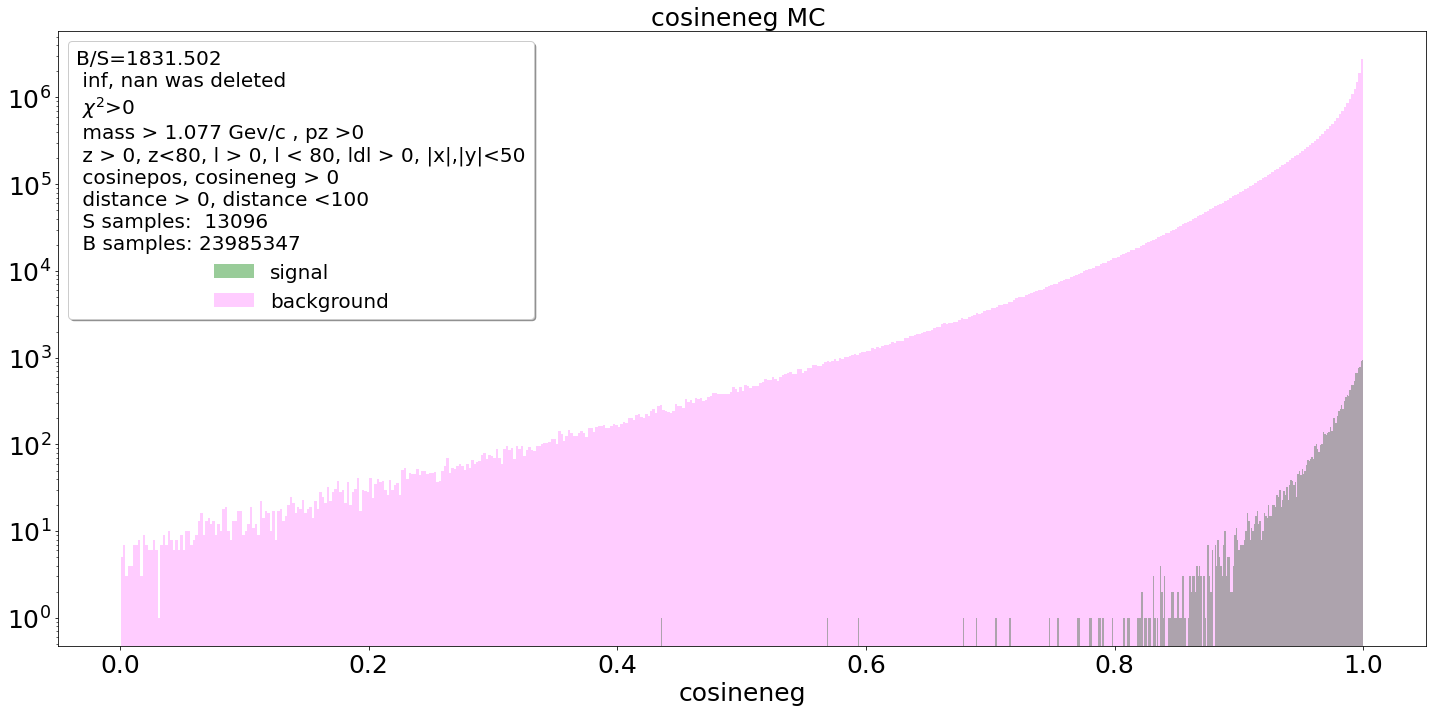

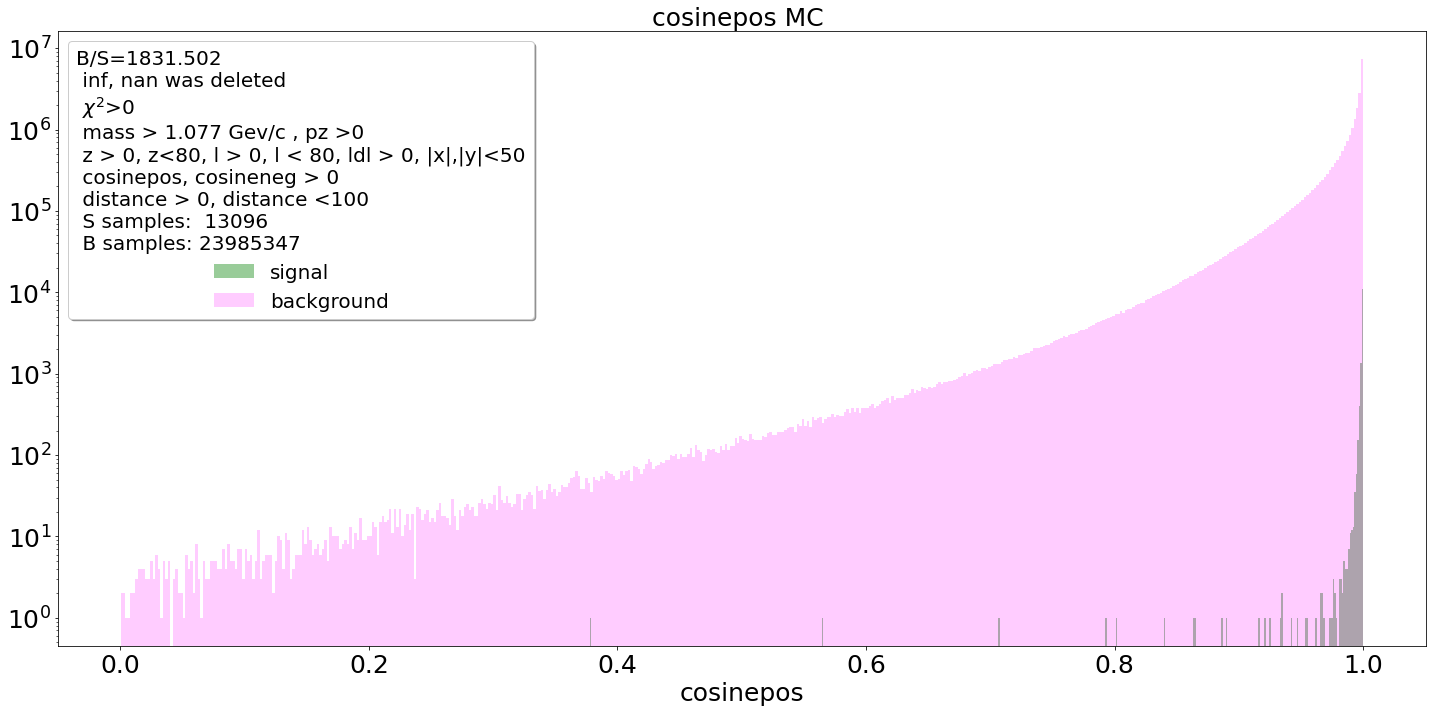

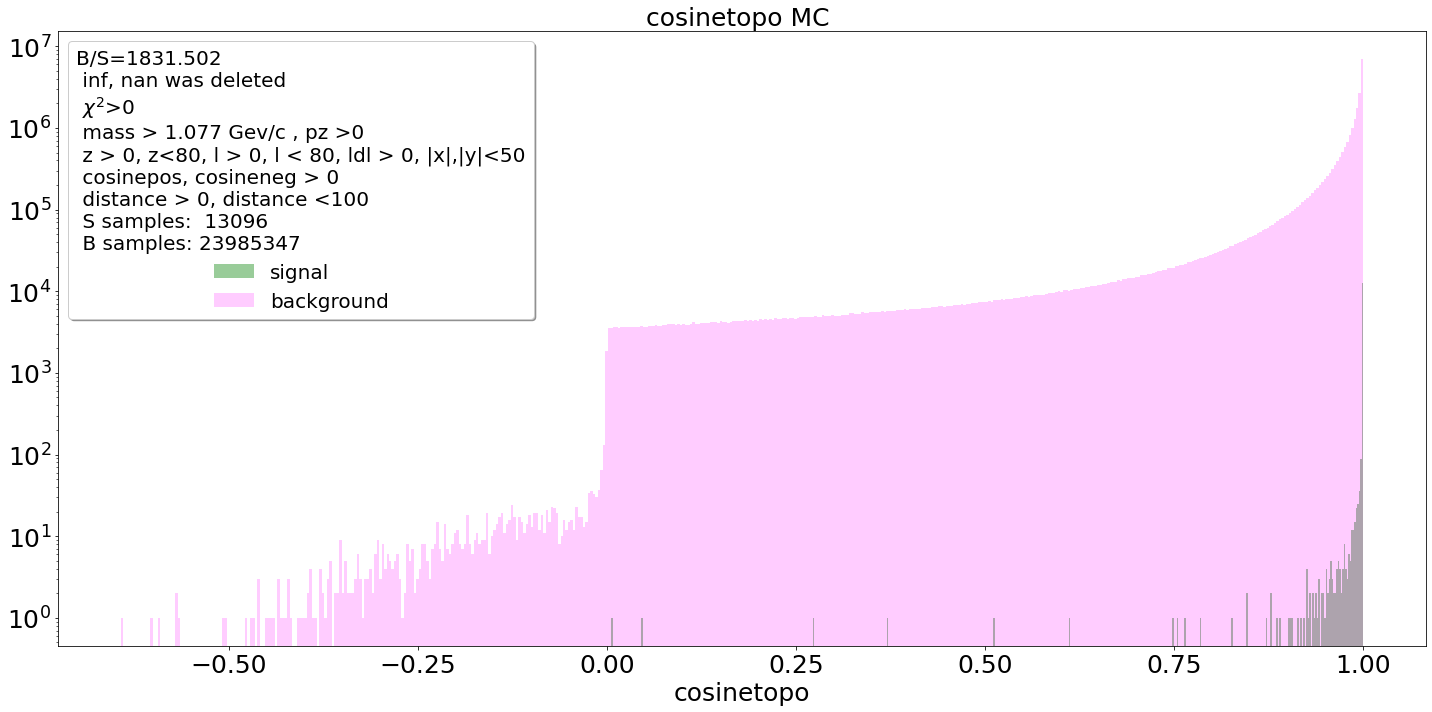

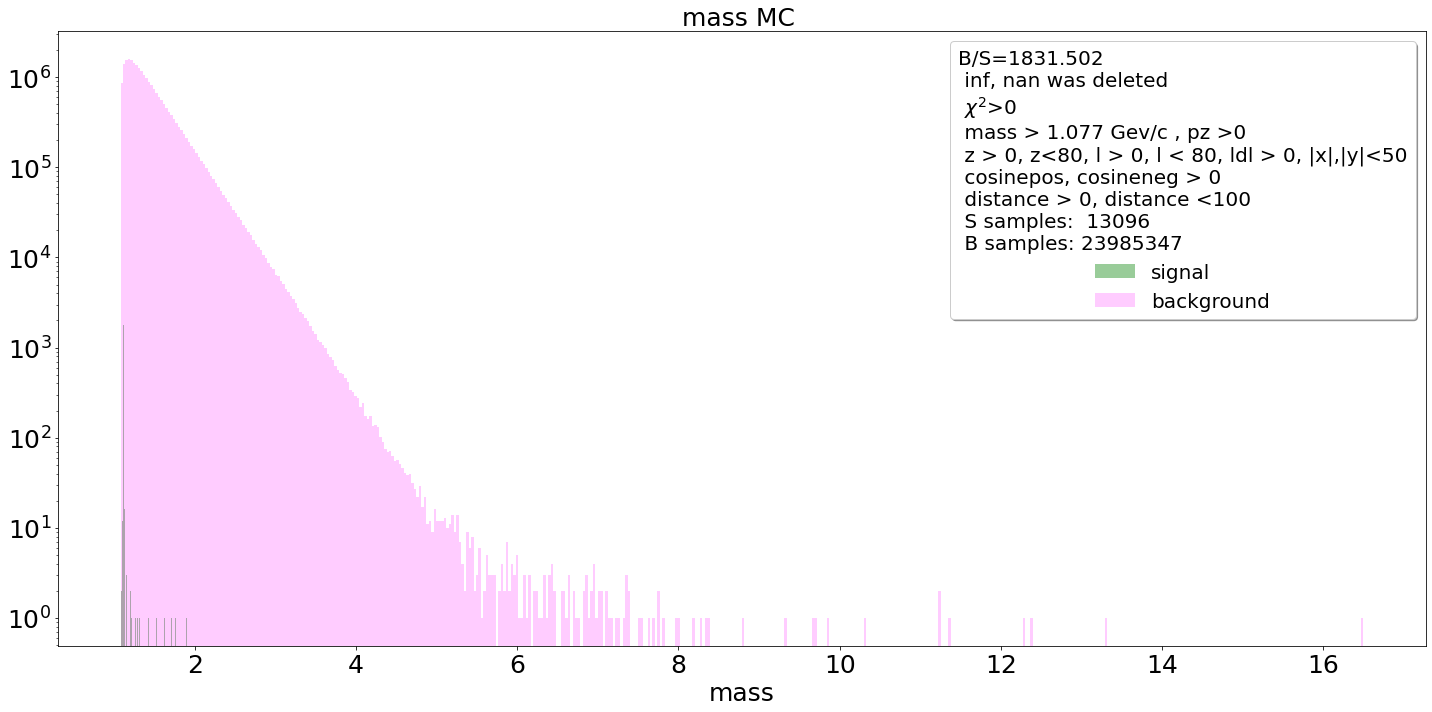

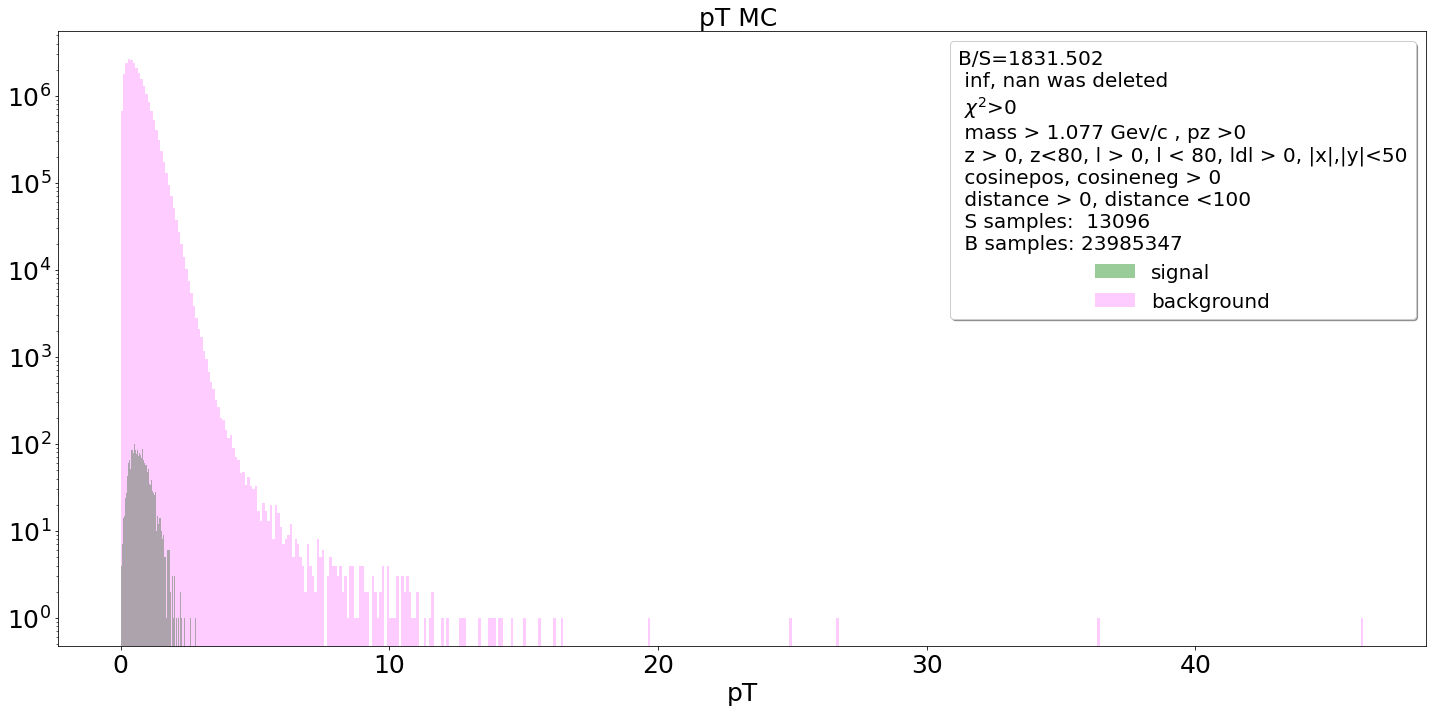

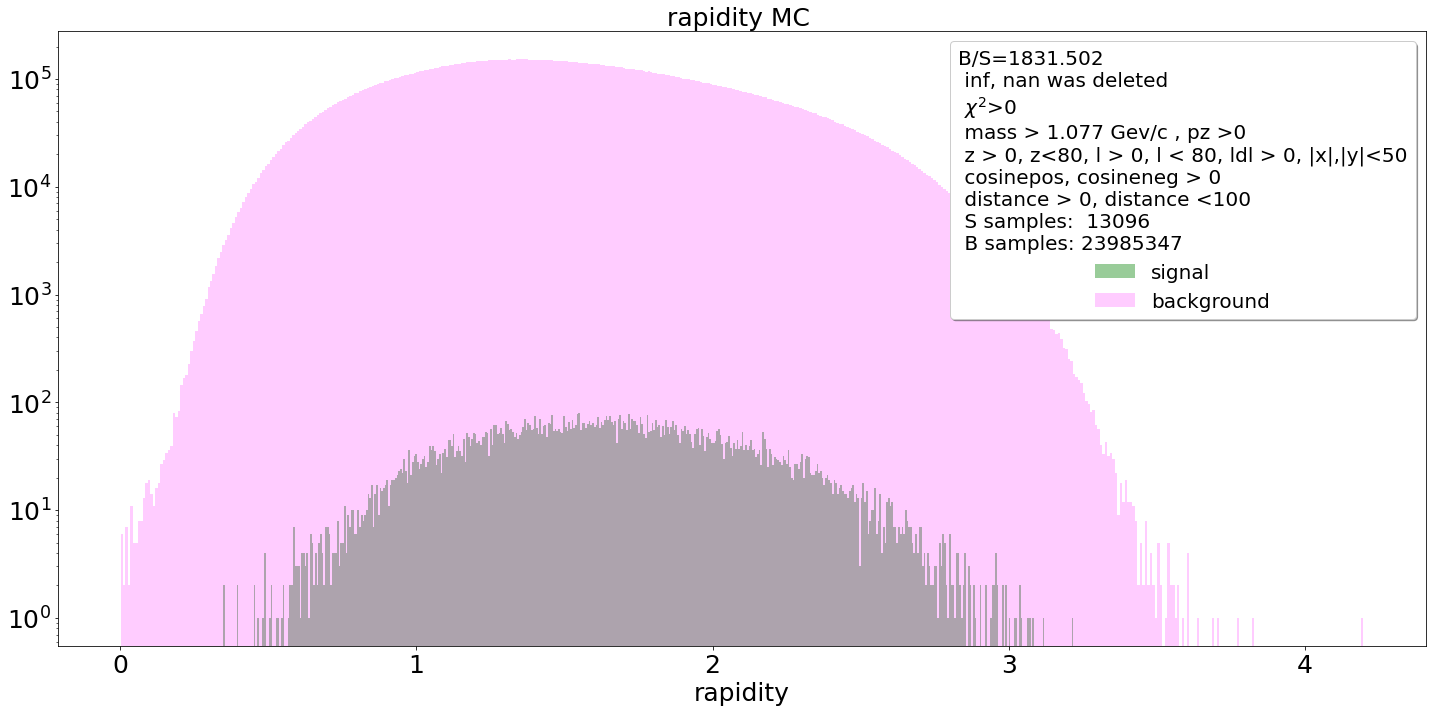

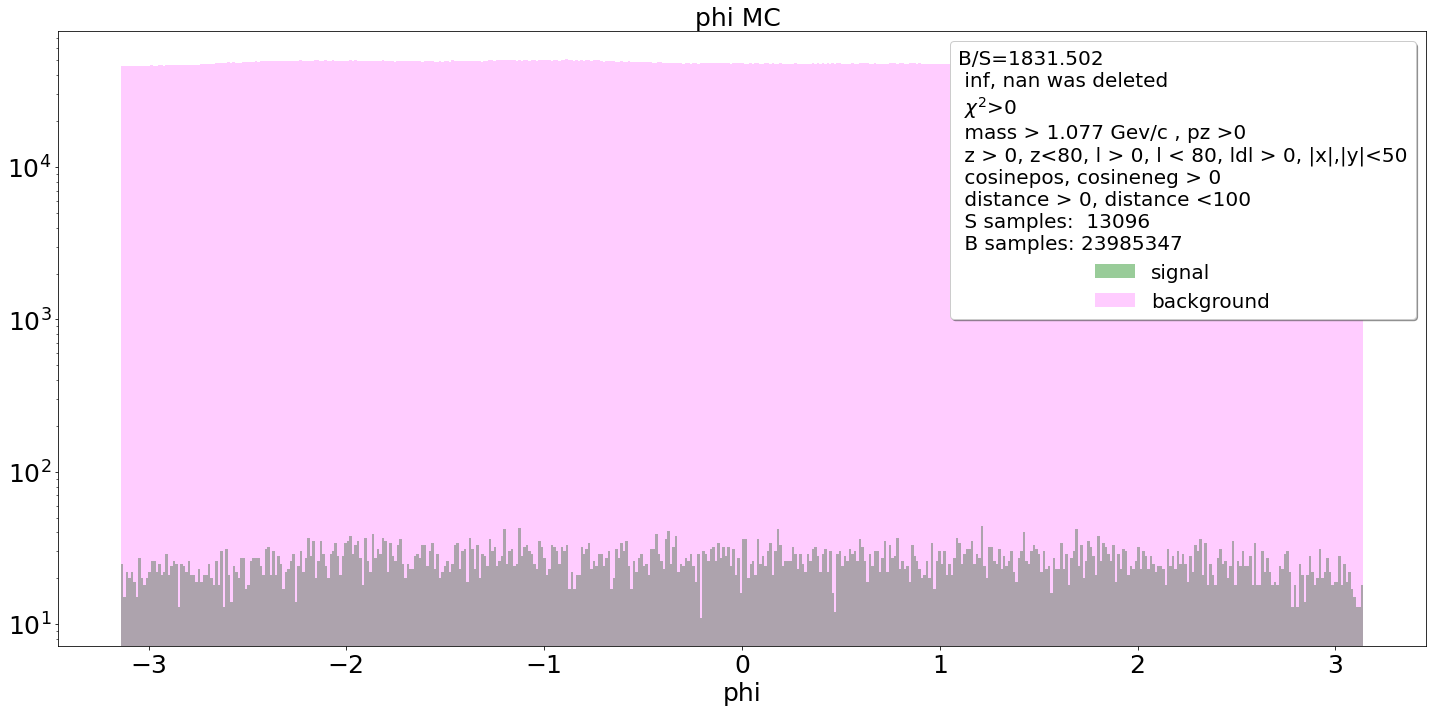

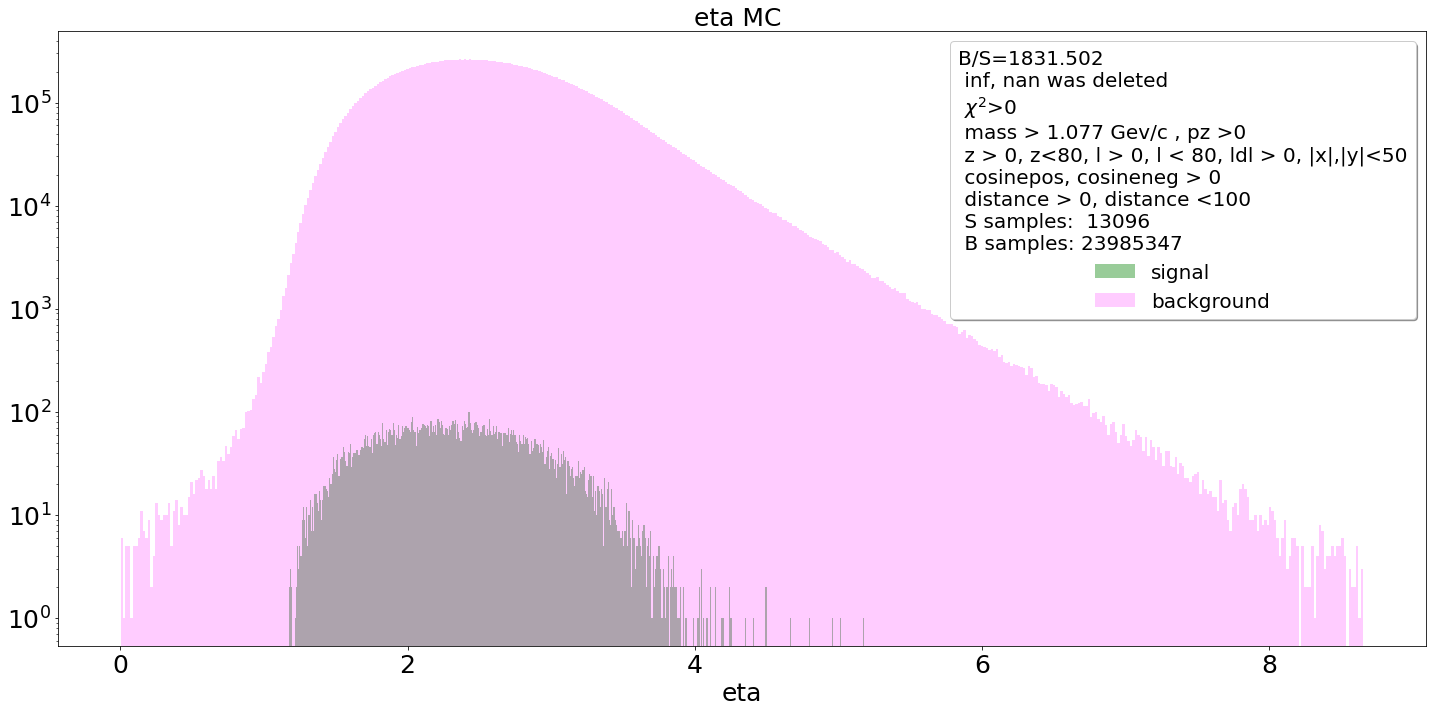

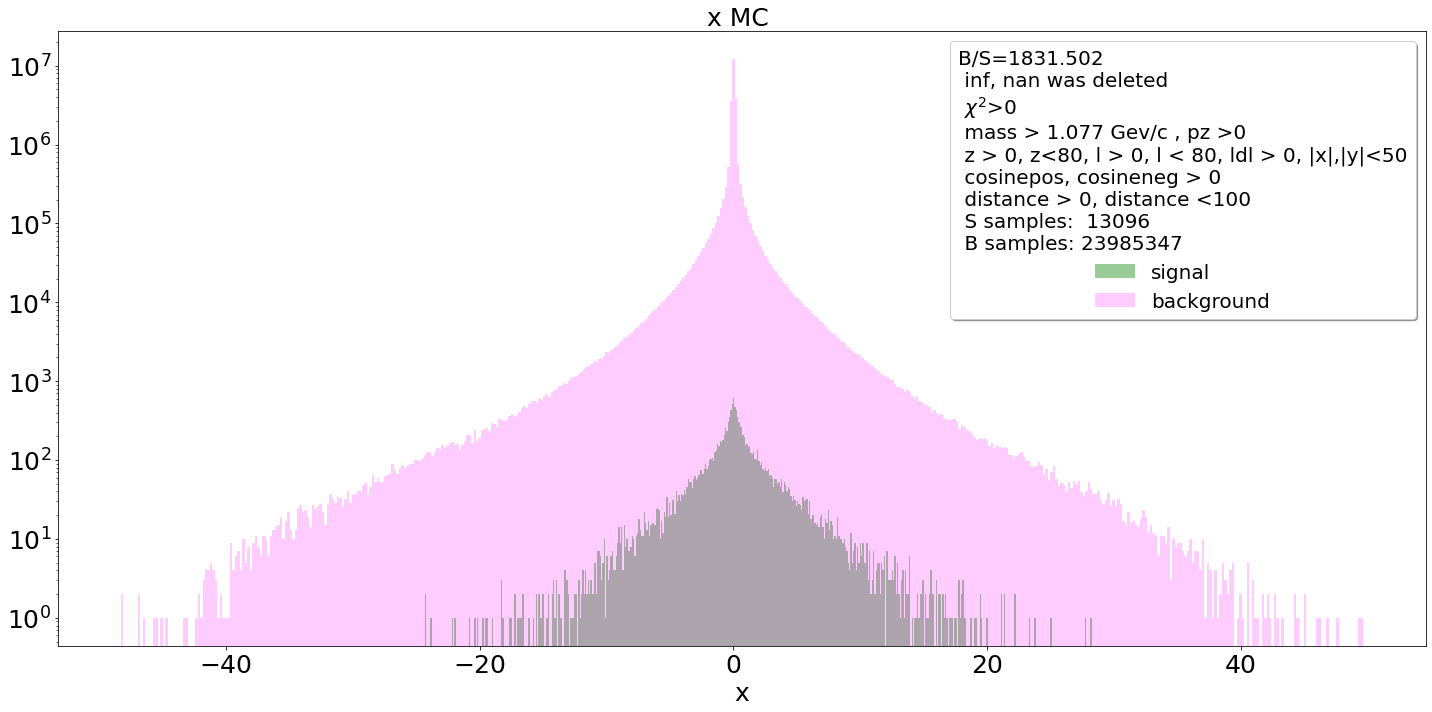

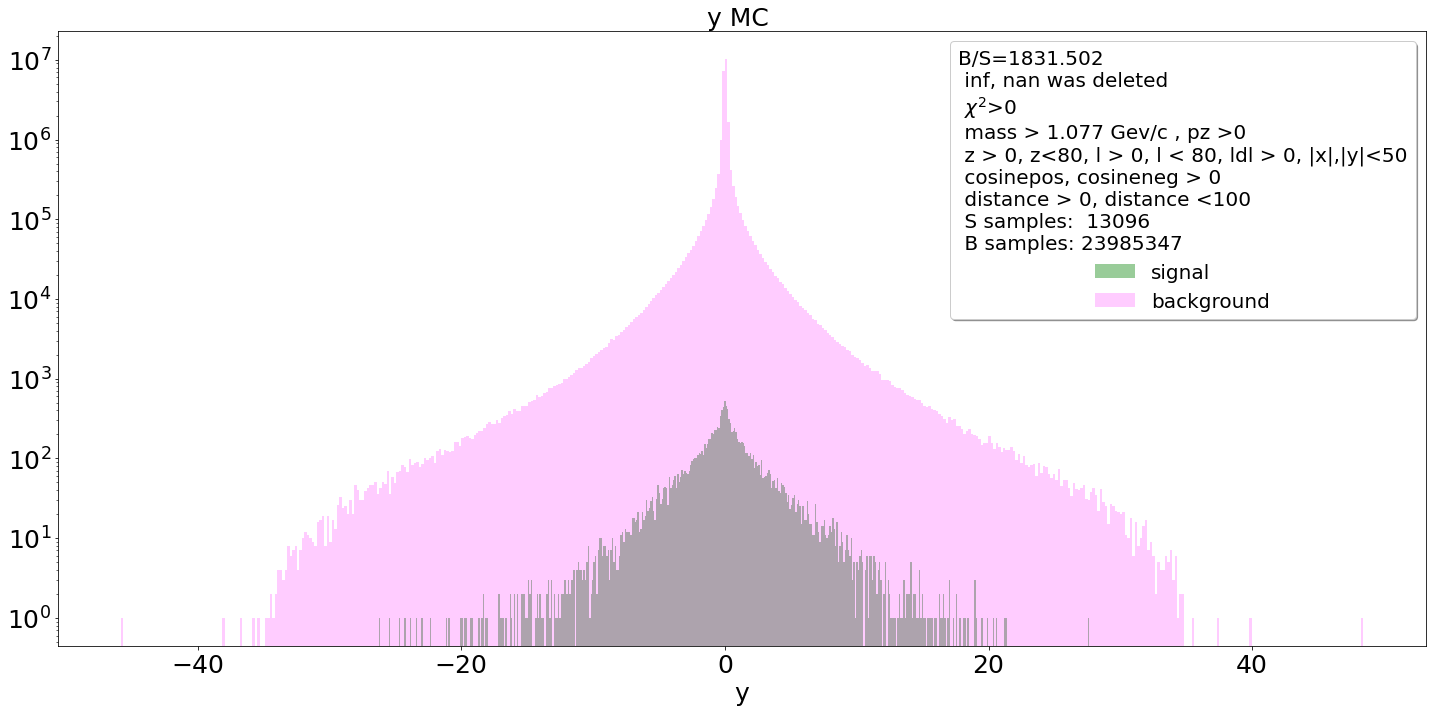

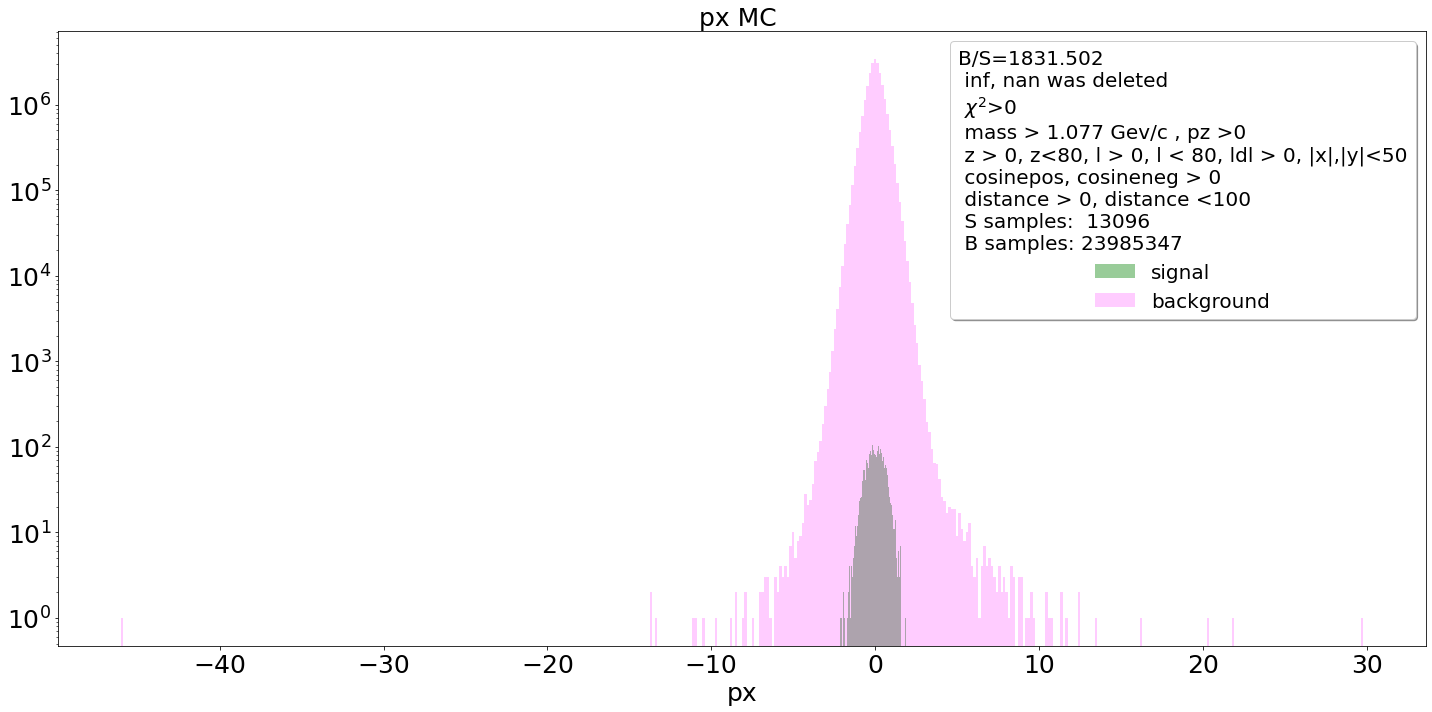

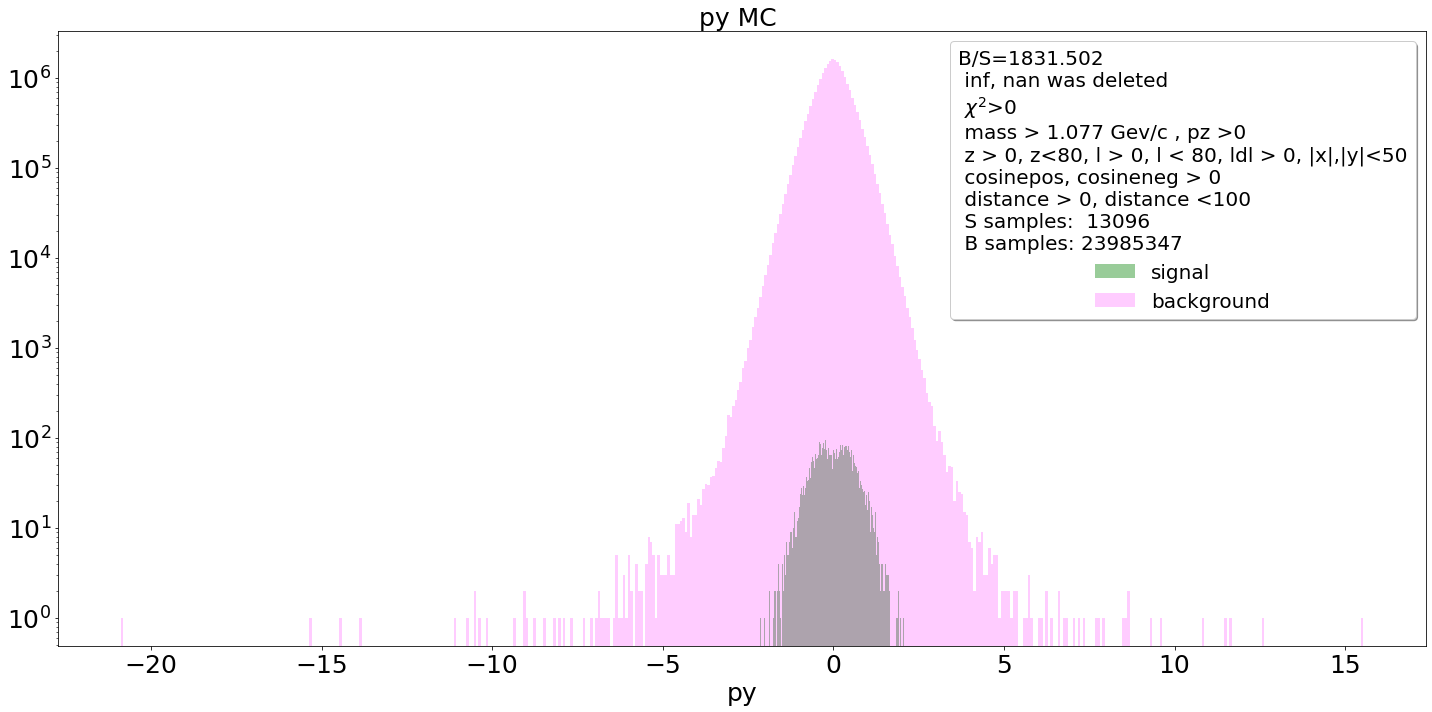

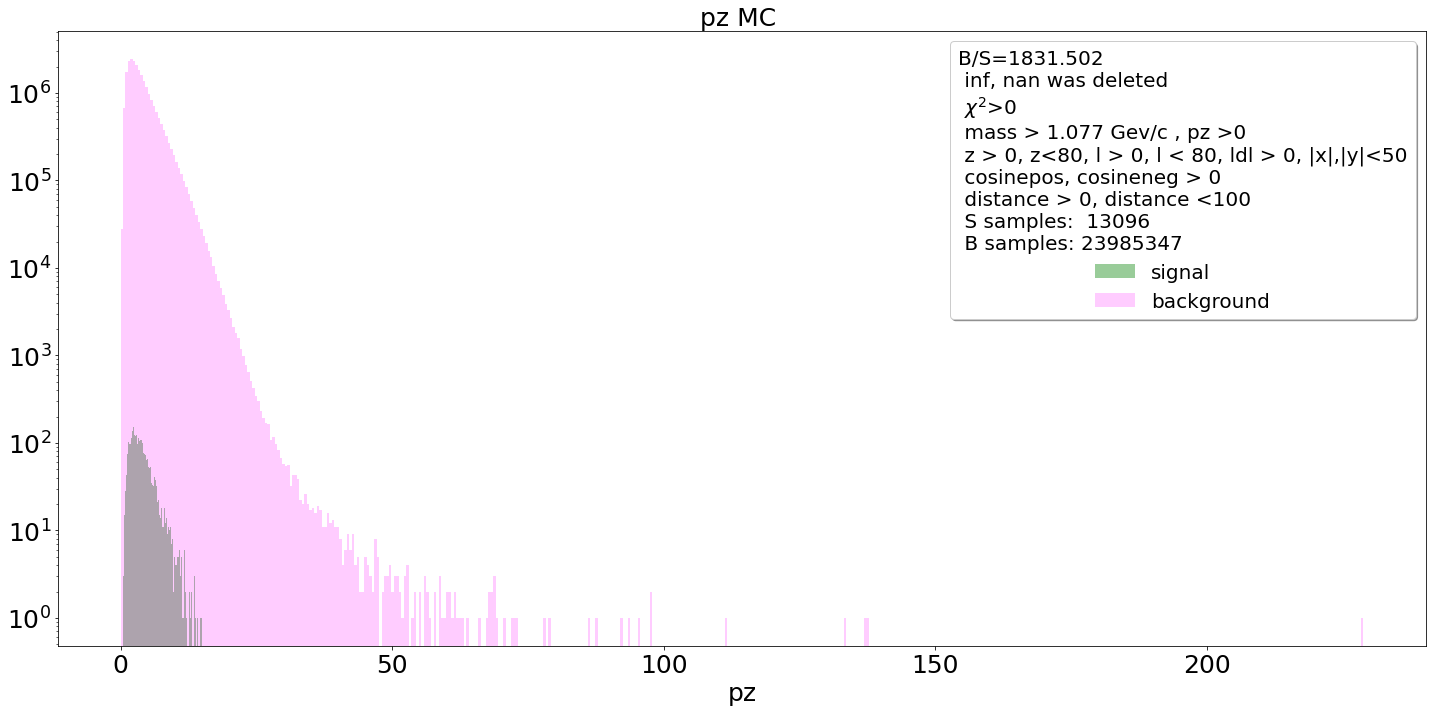

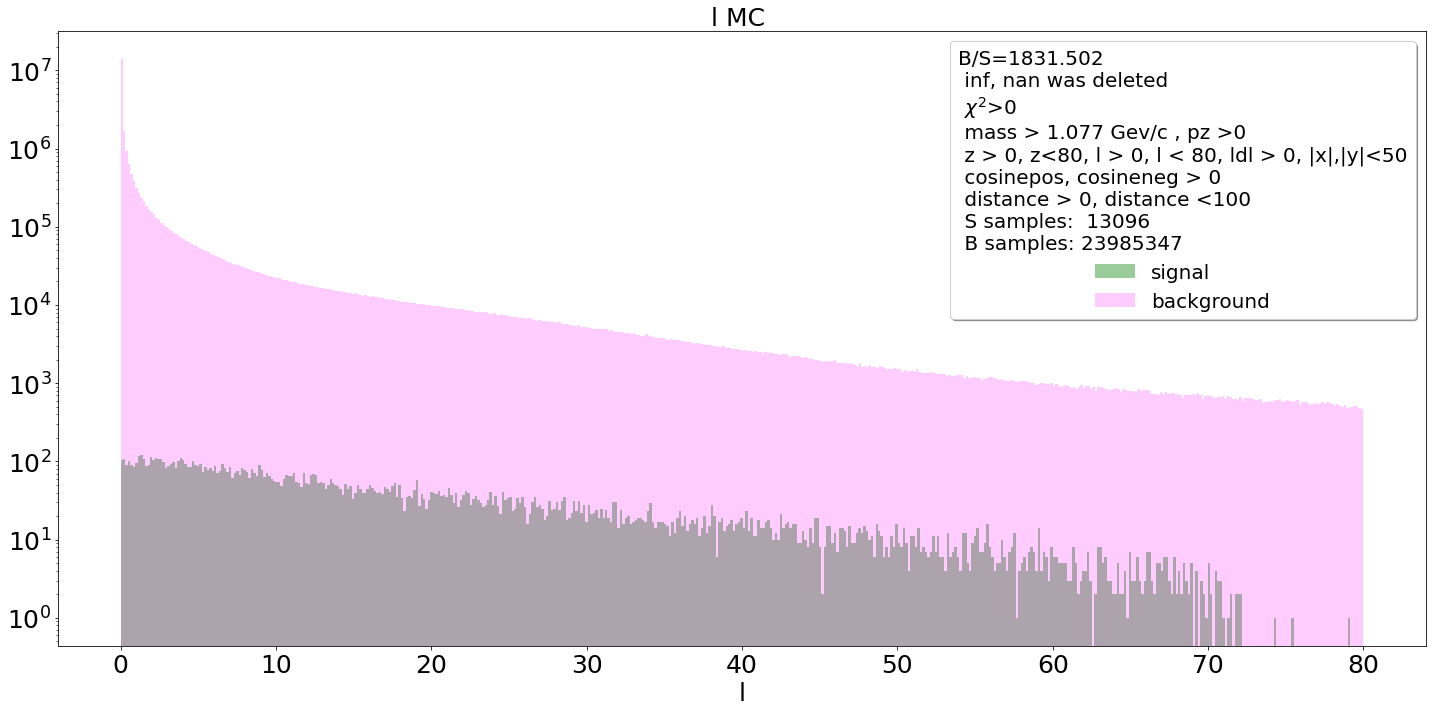

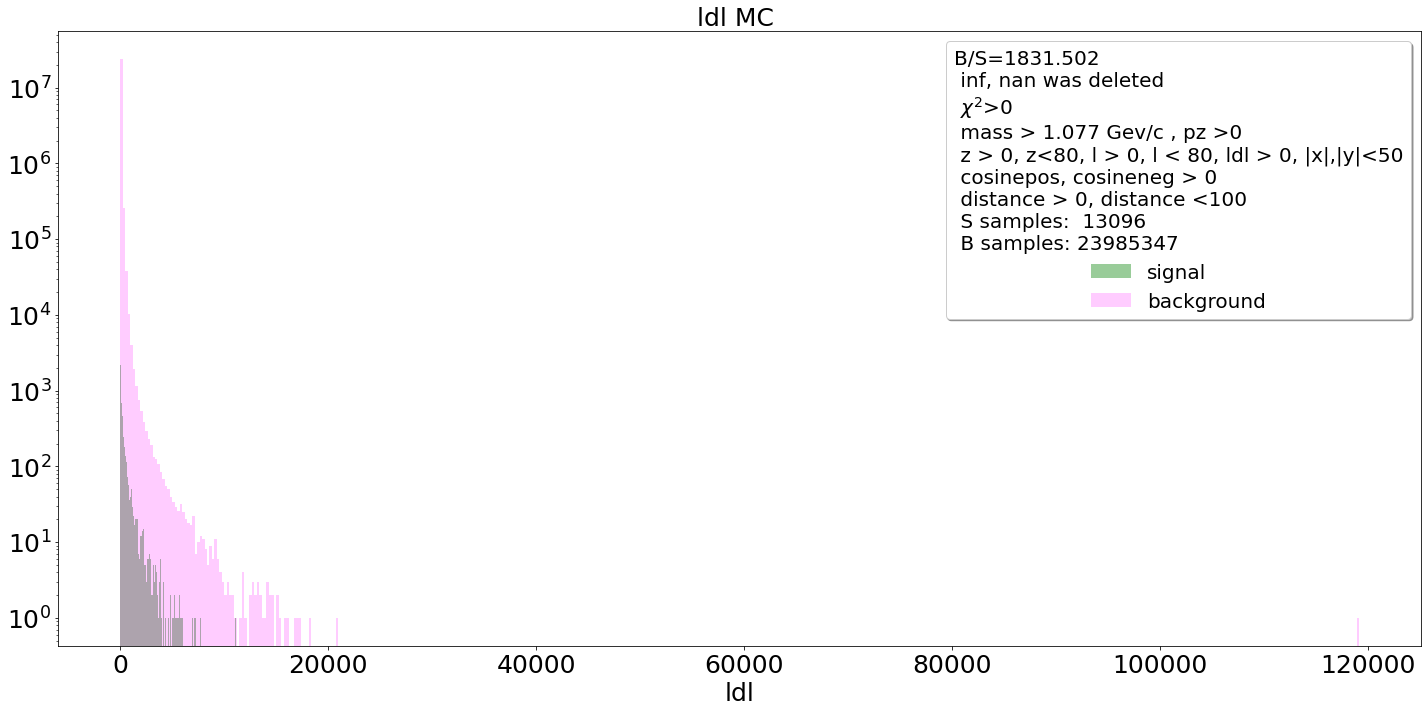

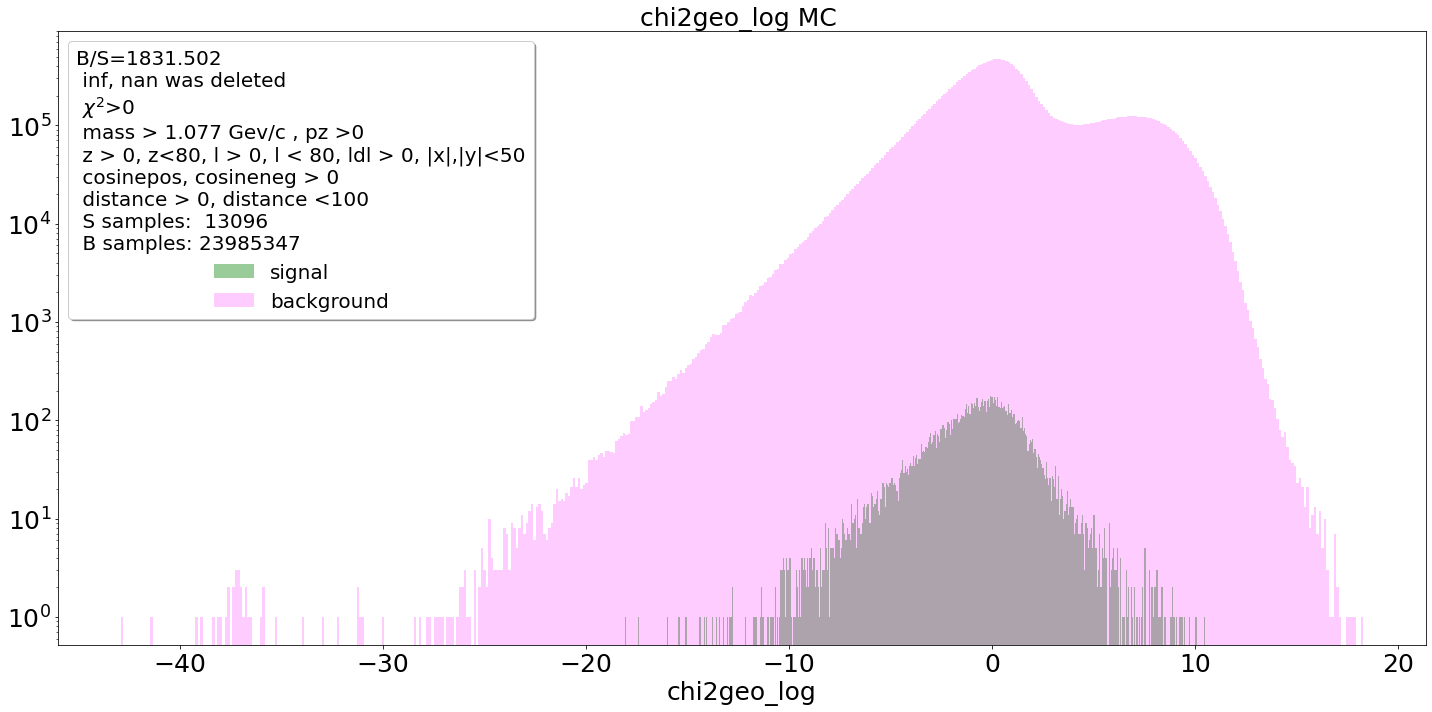

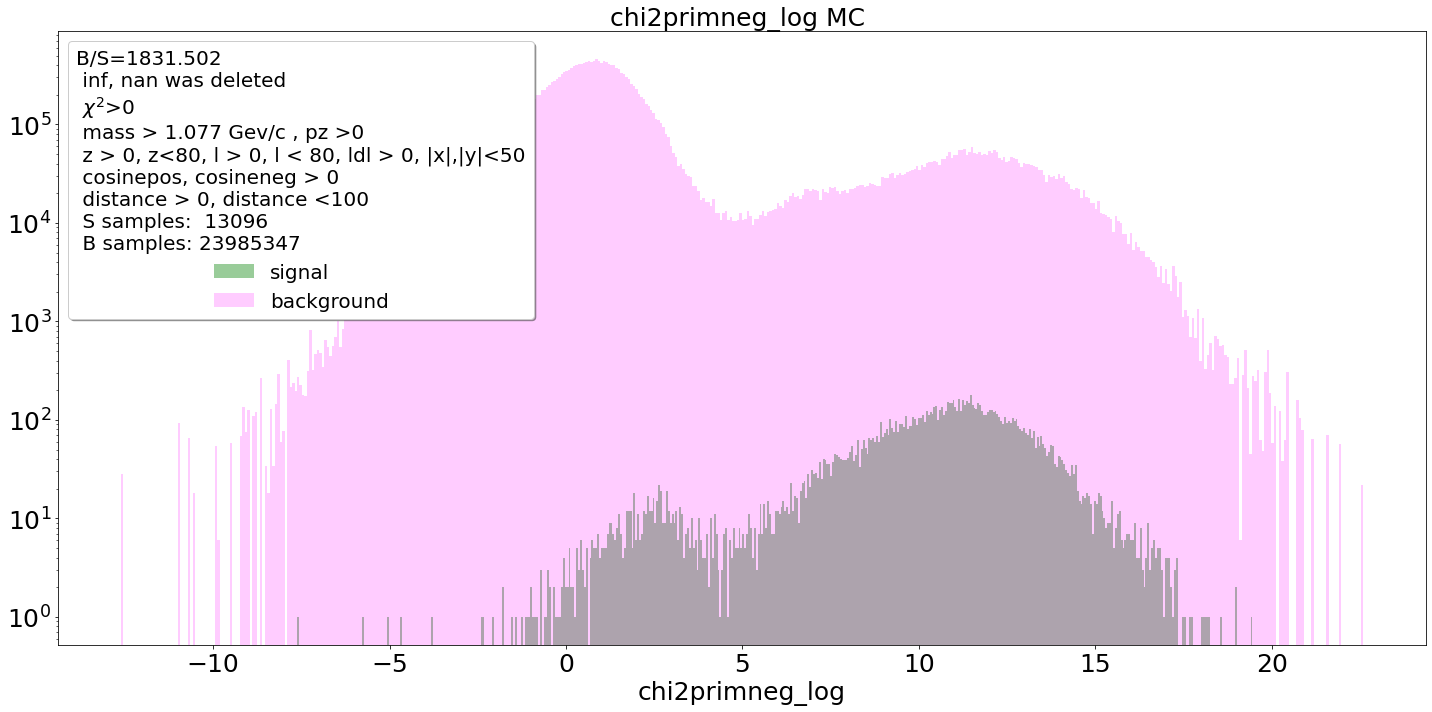

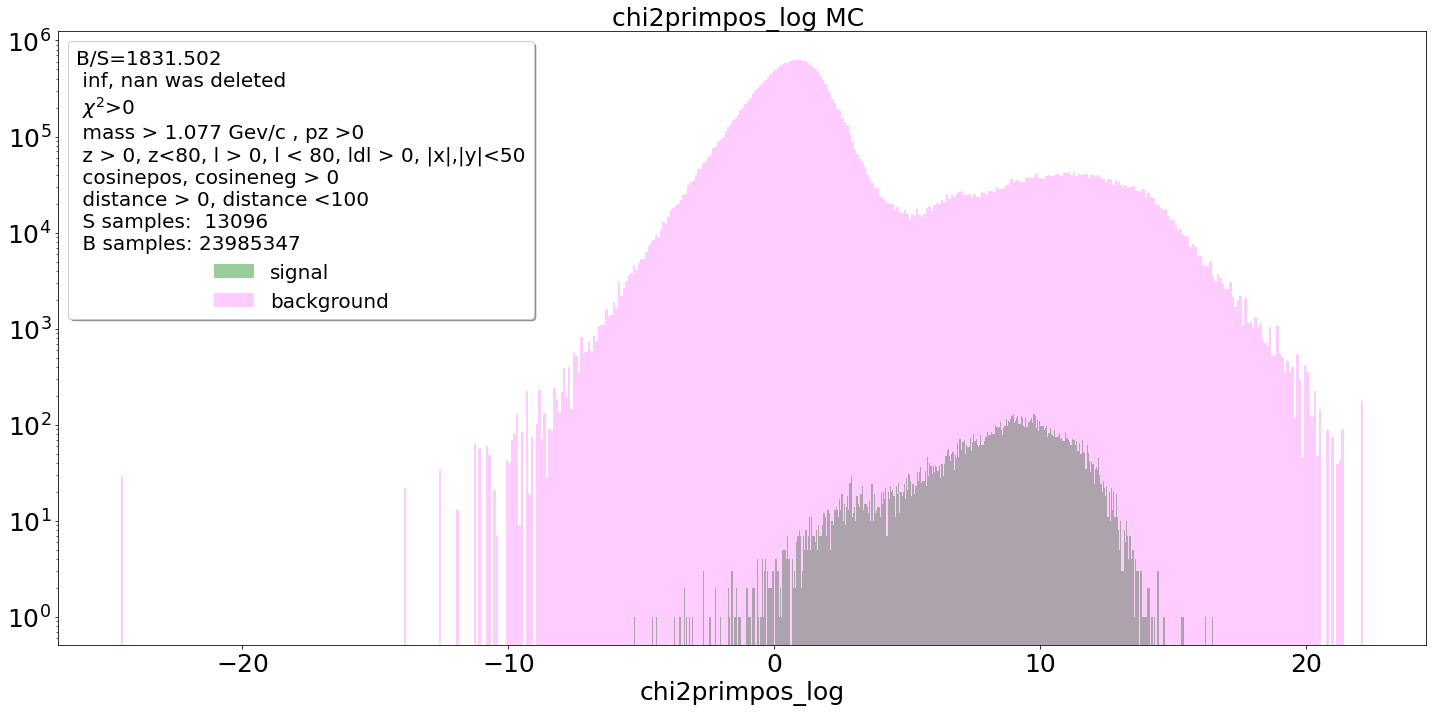

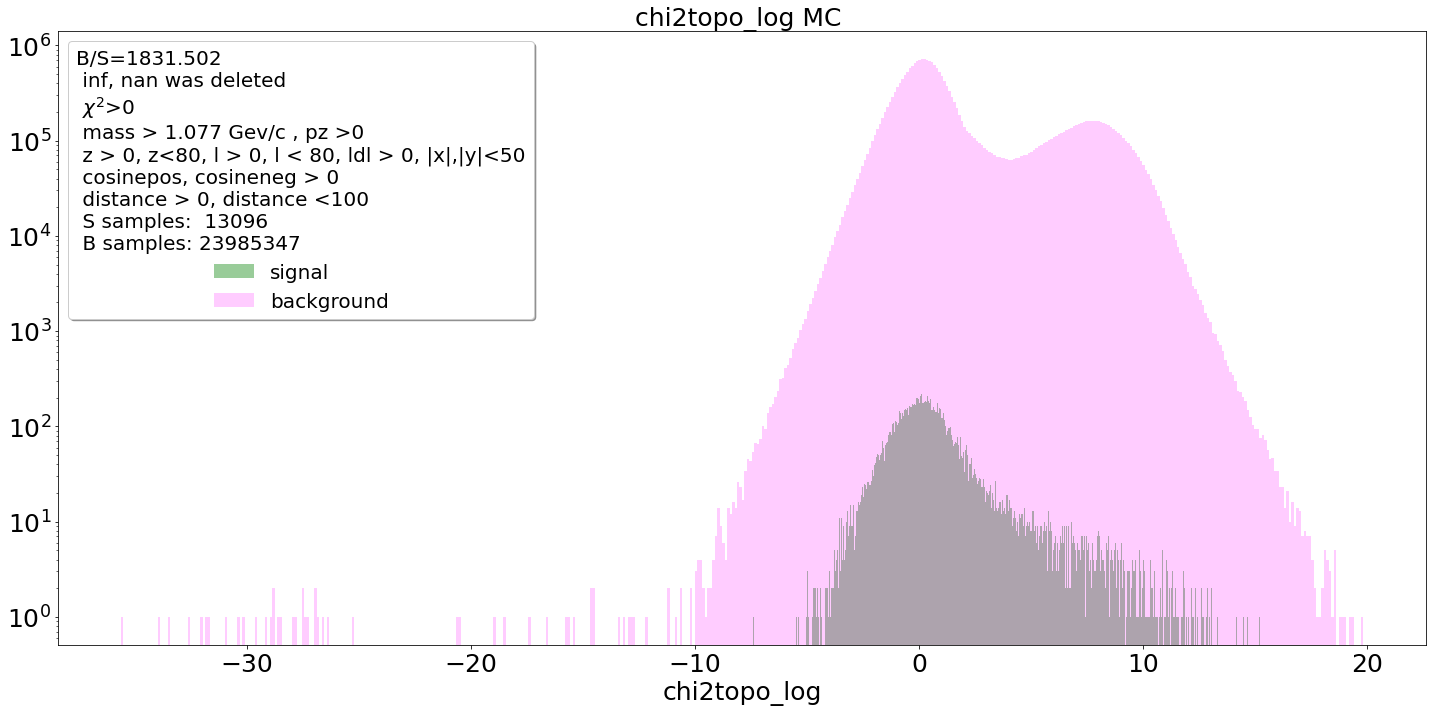

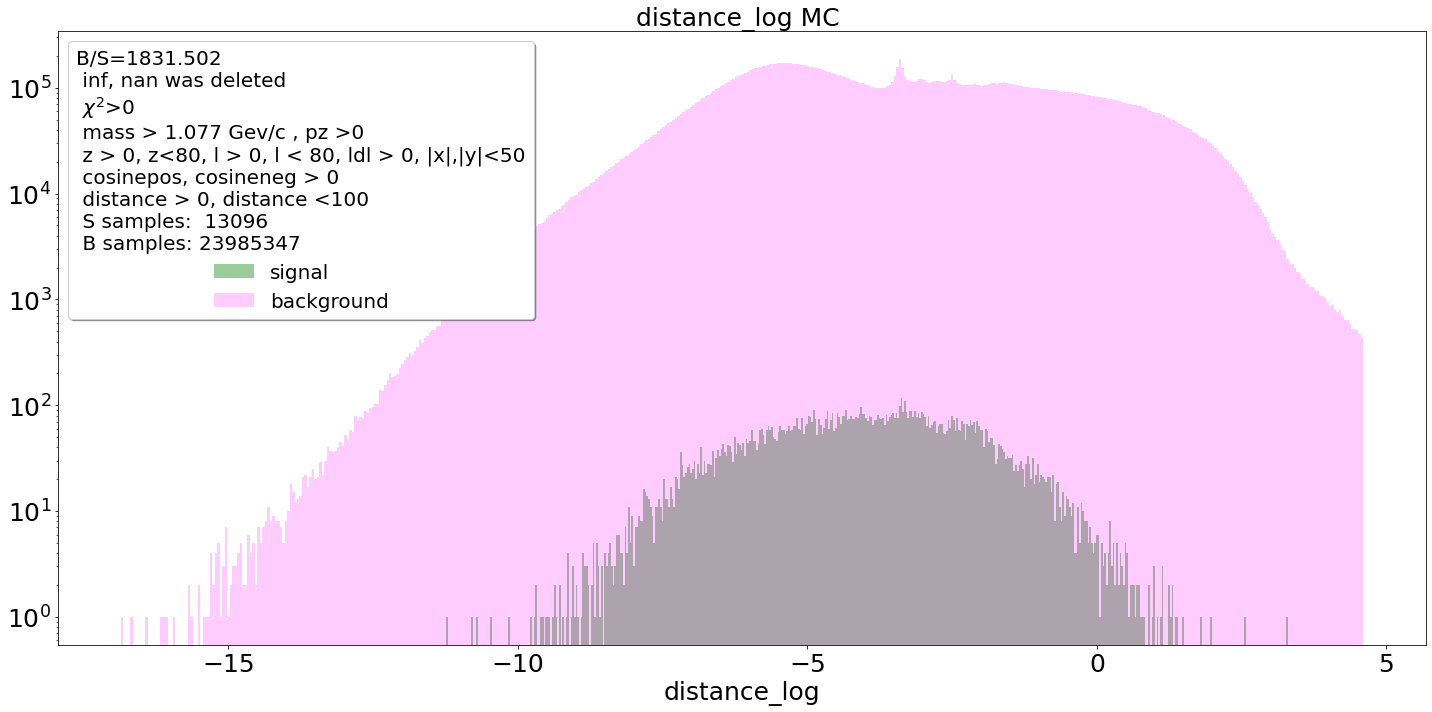

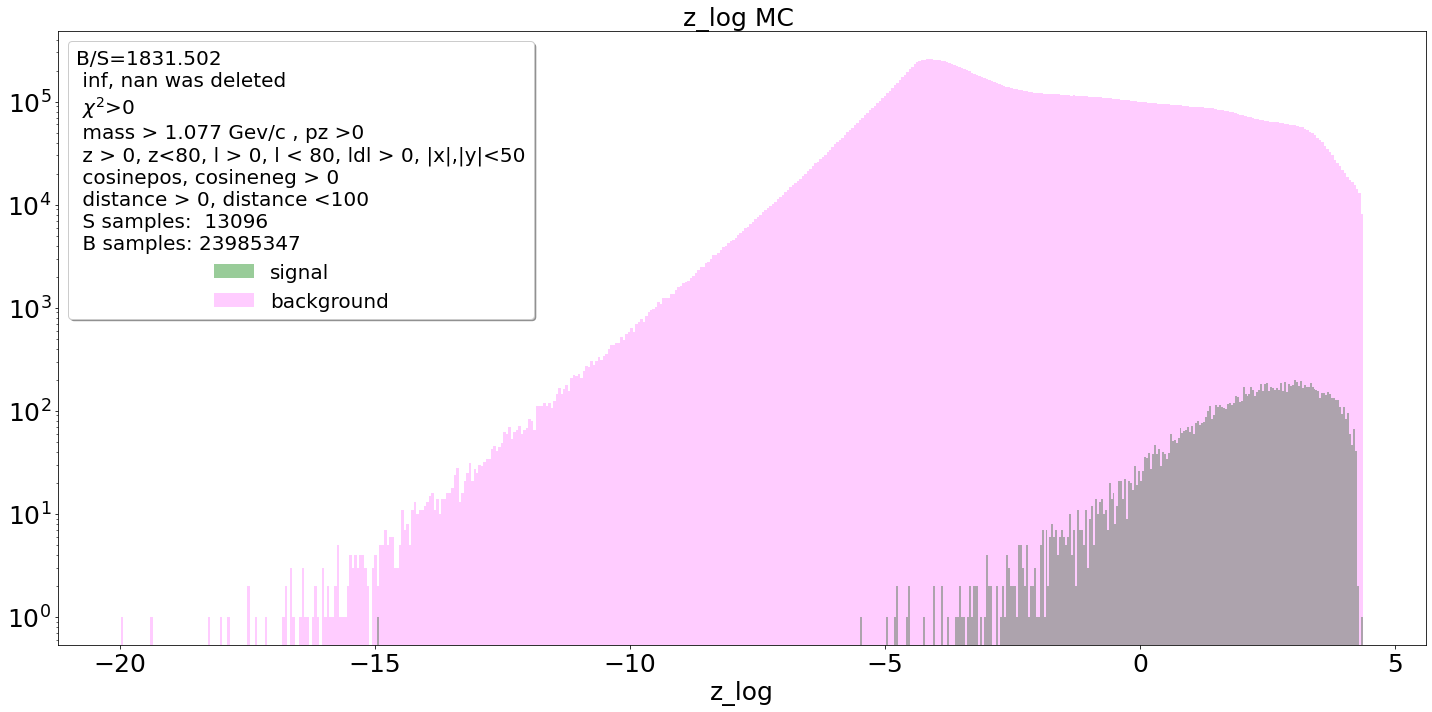

In [22]:
for feat in features:
    hist_variables(sgn4, bgr4, feat, pdf_cuts)

In [23]:
pdf_cuts.close()